In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from math import cos, sin
import os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Unzipping the dataset
!cp '/content/drive/MyDrive/AFLW2000-3D.zip' './'
!unzip -q '/content/AFLW2000-3D.zip'

In [6]:
# Path to the extracted dataset
path = '/content/AFLW2000'
img_files = os.listdir(path)
img_files.sort()

In [7]:
# Remove the code file from the list
img_files = [file for file in img_files if file.endswith(('jpg', 'mat'))]


In [8]:
# Split images into .JPG and .Mat files
jpg_files = [name for name in img_files if 'jpg' in name]
mat_files = [name for name in img_files if 'mat' in name]

In [9]:
# Function to extract labels (pitch, yaw, roll) from .mat files
def extract_labels(file_path):
    mat_file = sio.loadmat(file_path)
    pose_parameters = mat_file["Pose_Para"][0][:3]
    return pose_parameters


In [10]:
# Landmarks indices for the important features
landmark_indices = [4, 152, 61, 291, 50, 280, 55, 285, 33, 263, 159, 386, 10, 234, 454, 127, 356]

In [11]:
# Extract features and labels
x_points = []
y_points = []
labels = []

In [12]:
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    for jpg, mat in zip(jpg_files, mat_files):
        image = cv2.imread(os.path.join(path, jpg))
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            for face in results.multi_face_landmarks:
                x_temp = []
                y_temp = []
                for index in landmark_indices:
                    landmark = face.landmark[index]
                    shape = image.shape
                    relative_x = int(landmark.x * shape[1])
                    relative_y = int(landmark.y * shape[0])
                    x_temp.append(relative_x)
                    y_temp.append(relative_y)
                x_points.append(x_temp)
                y_points.append(y_temp)
                labels.append(extract_labels(os.path.join(path, mat)))

In [13]:
# Create column names for x and y features using landmarks names
landmarks_dict = {
    4: "nose_tip", 152: "chin", 61: "left_corner_of_mouth", 291: "right_corner_of_mouth", 50: "left_cheek",
    280: "right_cheek", 55: "left_eyebrow_outer", 285: "right_eyebrow_outer", 33: "left_eye_pupil", 263: "right_eye_pupil",
    159: "left_eye_iris", 386: "right_eye_iris", 10: "top_of_head", 234: "left_earlobe", 454: "right_earlobe",
    127: "left_temple", 356: "right_temple"
}

In [14]:
columns = []
for index in landmarks_dict.keys():
    columns.append('x_' + landmarks_dict[index])
for index in landmarks_dict.keys():
    columns.append('y_' + landmarks_dict[index])

In [15]:
# Convert to DataFrame
x_points = np.array(x_points)
y_points = np.array(y_points)
labels = np.array(labels)
X = np.hstack((x_points, y_points))
points_df = pd.DataFrame(X, columns=columns)

In [16]:
points_df

,x_nose_tip,x_chin,x_left_corner_of_mouth,x_right_corner_of_mouth,x_left_cheek,x_right_cheek,x_left_eyebrow_outer,x_right_eyebrow_outer,x_left_eye_pupil,x_right_eye_pupil,...,y_right_eyebrow_outer,y_left_eye_pupil,y_right_eye_pupil,y_left_eye_iris,y_right_eye_iris,y_top_of_head,y_left_earlobe,y_right_earlobe,y_left_temple,y_right_temple
0,220,217,181,258,152,298,208,249,159,301,...,201,198,213,194,205,133,202,223,182,204
1,187,220,201,230,202,262,208,222,209,265,...,212,224,226,219,220,175,244,252,230,235
2,144,142,123,157,107,171,133,149,109,168,...,316,322,321,319,319,291,331,329,322,321
3,207,260,211,269,172,285,180,214,159,270,...,207,241,205,232,204,171,252,200,238,183
4,219,247,205,264,163,286,196,226,158,273,...,201,229,204,218,200,148,267,226,247,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,240,218,191,253,154,285,214,249,157,284,...,205,218,217,211,210,148,234,231,215,214
1849,255,228,199,266,169,296,230,267,174,297,...,201,210,216,206,210,144,221,229,201,212
1850,274,240,228,290,212,322,271,302,226,331,...,221,218,248,216,238,174,230,273,213,256
1851,226,213,185,254,148,299,212,254,155,305,...,199,203,218,198,209,129,211,233,190,213


In [17]:
# Normalize function
def normalize(df):
    normalized_df = df.copy()
    for dim in ['x_', 'y_']:
        for feature in [dim + landmarks_dict[idx] for idx in landmark_indices]:
            normalized_df[feature] = normalized_df[feature] - normalized_df[dim + 'nose_tip']
        diff = normalized_df[dim + 'top_of_head'] - normalized_df[dim + 'nose_tip']
        for feature in [dim + landmarks_dict[idx] for idx in landmark_indices]:
            normalized_df[feature] = normalized_df[feature] / diff
    return normalized_df

In [18]:
normalized_df = normalize(points_df)
labels_df = pd.DataFrame(labels, columns=['pitch', 'yaw', 'roll'])
df = pd.concat([normalized_df, labels_df], axis=1)
df.dropna(inplace=True)

In [19]:
df

,x_nose_tip,x_chin,x_left_corner_of_mouth,x_right_corner_of_mouth,x_left_cheek,x_right_cheek,x_left_eyebrow_outer,x_right_eyebrow_outer,x_left_eye_pupil,x_right_eye_pupil,...,y_left_eye_iris,y_right_eye_iris,y_top_of_head,y_left_earlobe,y_right_earlobe,y_left_temple,y_right_temple,pitch,yaw,roll
0,0.0,0.927350,0.773504,1.102564,0.649573,1.273504,0.888889,1.064103,0.679487,1.286325,...,1.458647,1.541353,1.0,1.518797,1.676692,1.368421,1.533835,-0.399231,0.018227,0.085676
1,0.0,1.004566,0.917808,1.050228,0.922374,1.196347,0.949772,1.013699,0.954338,1.210046,...,1.251429,1.257143,1.0,1.394286,1.440000,1.314286,1.342857,0.470065,1.189533,0.300959
2,0.0,1.014286,0.878571,1.121429,0.764286,1.221429,0.950000,1.064286,0.778571,1.200000,...,1.096220,1.096220,1.0,1.137457,1.130584,1.106529,1.103093,-0.184650,0.881137,-0.236852
3,0.0,1.420765,1.153005,1.469945,0.939891,1.557377,0.983607,1.169399,0.868852,1.475410,...,1.356725,1.192982,1.0,1.473684,1.169591,1.391813,1.070175,-0.175379,0.299208,-0.373374
4,0.0,1.235000,1.025000,1.320000,0.815000,1.430000,0.980000,1.130000,0.790000,1.365000,...,1.472973,1.351351,1.0,1.804054,1.527027,1.668919,1.391892,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.0,0.935622,0.819742,1.085837,0.660944,1.223176,0.918455,1.068670,0.673820,1.218884,...,1.425676,1.418919,1.0,1.581081,1.560811,1.452703,1.445946,-0.306358,-0.283822,0.038554
1849,0.0,0.901186,0.786561,1.051383,0.667984,1.169960,0.909091,1.055336,0.687747,1.173913,...,1.430556,1.458333,1.0,1.534722,1.590278,1.395833,1.472222,-0.367547,-0.429723,0.122791
1850,0.0,0.802676,0.762542,0.969900,0.709030,1.076923,0.906355,1.010033,0.755853,1.107023,...,1.241379,1.367816,1.0,1.321839,1.568966,1.224138,1.471264,-0.156035,0.567114,-0.108536
1851,0.0,0.887500,0.770833,1.058333,0.616667,1.245833,0.883333,1.058333,0.645833,1.270833,...,1.534884,1.620155,1.0,1.635659,1.806202,1.472868,1.651163,-0.197102,-0.070430,0.105118


In [20]:
# Train-test split the data
X = df.drop(columns=['pitch', 'yaw', 'roll'])
y = df[['pitch', 'yaw', 'roll']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return model, r2, mse

In [22]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

In [24]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model_results = {}
    for target_name in ['pitch', 'yaw', 'roll']:
        # Select the target column for training and testing
        y_train_single = y_train[target_name]
        y_test_single = y_test[target_name]

        # Train and evaluate the model for the current target
        trained_model, r2, mse = train_and_evaluate(model, X_train, y_train_single, X_test, y_test_single)
        model_results[target_name] = {"model": trained_model, "r2": r2, "mse": mse}
        print(f"{name} ({target_name}) - R2 Score: {r2:.4f}, MSE: {mse:.4f}")

    # Store results for the current model
    results[name] = model_results

Linear Regression (pitch) - R2 Score: 0.5065, MSE: 0.0360
Linear Regression (yaw) - R2 Score: 0.8673, MSE: 0.0336
Linear Regression (roll) - R2 Score: 0.0173, MSE: 0.0990
Decision Tree (pitch) - R2 Score: -17.6780, MSE: 1.3633
Decision Tree (yaw) - R2 Score: 0.4555, MSE: 0.1378
Decision Tree (roll) - R2 Score: 0.0168, MSE: 0.0991
Random Forest (pitch) - R2 Score: -0.4073, MSE: 0.1027
Random Forest (yaw) - R2 Score: 0.8818, MSE: 0.0299
Random Forest (roll) - R2 Score: -0.4158, MSE: 0.1427
Gradient Boosting (pitch) - R2 Score: -5.5838, MSE: 0.4805
Gradient Boosting (yaw) - R2 Score: 0.8847, MSE: 0.0292
Gradient Boosting (roll) - R2 Score: -0.2977, MSE: 0.1308
XGBoost (pitch) - R2 Score: -5.4554, MSE: 0.4712
XGBoost (yaw) - R2 Score: 0.6564, MSE: 0.0870
XGBoost (roll) - R2 Score: 0.6810, MSE: 0.0321


In [26]:
# Find the best model for each target separately
best_models = {}
for target_name in ['pitch', 'yaw', 'roll']:
    best_model_name = max(models, key=lambda k: results[k][target_name]["r2"])
    best_models[target_name] = results[best_model_name][target_name]["model"]
    print(f"Best model for {target_name}: {best_model_name}")

Best model for pitch: Linear Regression
Best model for yaw: Gradient Boosting
Best model for roll: XGBoost


In [49]:
def draw_axis(img, pitch, yaw, roll, nose_x, nose_y, size=50):
    yaw = -yaw
    tdx = nose_x
    tdy = nose_y
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 3)
    return img


In [50]:
# Predicting on a random image from the dataset
index = np.random.randint(0, len(x_points))
image = cv2.imread(os.path.join(path, jpg_files[index]))

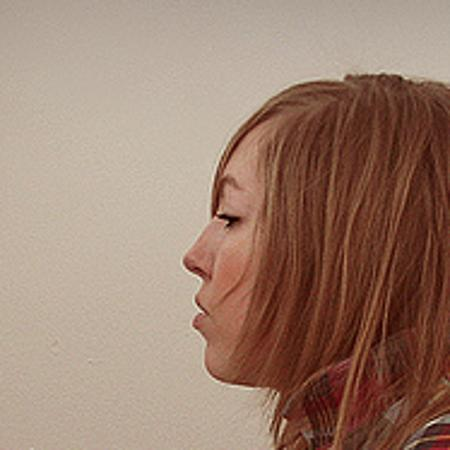

In [51]:
faceModule = mp.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face in results.multi_face_landmarks:
            for idx, landmark in enumerate(face.landmark):
                if idx in landmark_indices:
                    x = landmark.x
                    y = landmark.y
                    shape = image.shape
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)

cv2_imshow(image)

In [52]:
# Predicting pose angles using the best models
normalized_image_points = np.array(x_points[index].tolist() + y_points[index].tolist()).reshape(1, -1)
predicted_angles = {}
for target_name, model in best_models.items():
    predicted_angles[target_name] = model.predict(normalized_image_points)[0]

In [54]:
# Draw the predicted axes for pitch, yaw, and roll
image_with_axes = image.copy()
if len(predicted_angles) == 3:
    pitch, yaw, roll = predicted_angles['pitch'], predicted_angles['yaw'], predicted_angles['roll']
    nose_x, nose_y = x_points[index][landmark_indices.index(4)], y_points[index][landmark_indices.index(4)]
    image_with_axes = draw_axis(image_with_axes, pitch, yaw, roll, nose_x, nose_y)
else:
    print("Unable to draw axes. Invalid number of predicted angles.")


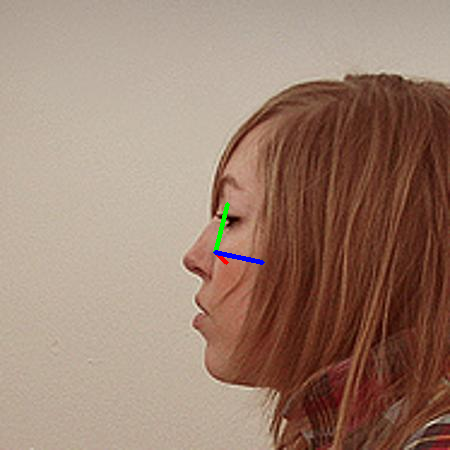

In [55]:
cv2_imshow(image_with_axes)